In [64]:
%load_ext autoreload
%autoreload 2
import numpy as np
import igraph
import matplotlib.pyplot as plt

from spring_embedding_model import SpringEmbeddingModel, SpringAttentionModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
def visualize_graph_from_matrix(A, node_positions, node_classes=None, ax=None):
    """
    Visualizes the graph using igraph.
    """

    
    g = igraph.Graph.Adjacency(A.tolist())
    g.vs['label'] = [str(i) for i in range(len(g.vs))]

    # adjust edge display properties for visibility
    g.es["curved"] = 0.2

    # set node and edge colors based on classes
    if node_classes is not None:
        unique_classes = sorted(set(node_classes))
        class_to_color = {cls: plt.cm.tab10(i) for i, cls in enumerate(unique_classes)}
        g.vs['color'] = [class_to_color[cls] for cls in node_classes]
        edge_colors = []
        for e in g.es:
            source = e.source
            cls = node_classes[source]
            edge_colors.append(class_to_color[cls])
        g.es["color"] = edge_colors

    layout = igraph.Layout(node_positions)
    if ax is None:
        ax = plt.gca()
    igraph.plot(
        g, 
        layout=layout, 
        vertex_label=g.vs['label'],  
        vertex_size=20,
        target=ax
    )

In [3]:
test_embeddings = np.array([
    [1, 1.5],
    [1.7, 1],
    [2, 2],
    [-1.5, -1],
    [-1, -1.7],
    [-2, -2]
])

In [59]:
gen_model = SpringEmbeddingModel(node_embeddings=test_embeddings)
gen_model_low_temp = SpringEmbeddingModel(node_embeddings=test_embeddings, beta=5)
gen_model_uncoupled = SpringEmbeddingModel(node_embeddings=test_embeddings, alpha=0.01, beta=5)
gen_model_coupled = SpringEmbeddingModel(node_embeddings=test_embeddings, alpha=10, beta=5)

In [52]:
A = np.zeros((6, 6))
for i in range(1000):
    A += gen_model_low_temp.generate(12)
A / 1000

array([[0.   , 0.027, 0.   , 0.196, 0.123, 0.007],
       [0.125, 0.   , 0.   , 0.301, 0.185, 0.009],
       [0.665, 0.647, 0.   , 0.727, 0.715, 0.196],
       [0.181, 0.107, 0.002, 0.   , 0.025, 0.   ],
       [0.268, 0.196, 0.013, 0.12 , 0.   , 0.   ],
       [0.74 , 0.655, 0.178, 0.657, 0.688, 0.   ]])

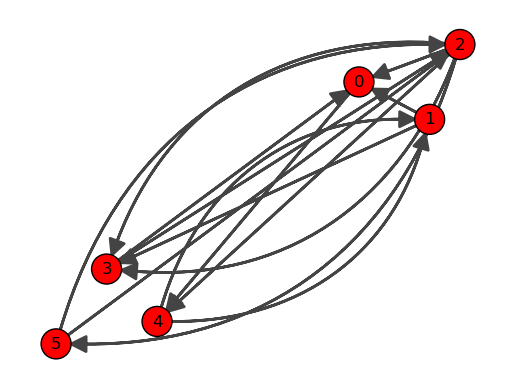

In [31]:
gen_net = gen_model.generate(expected_num_edges=12)
visualize_graph_from_matrix(gen_net, test_embeddings)

# experiments on parameters:
- beta is inverse temperature
- k controls sparsity
- alpha controls how coupled the ranking vs. community structure is

Can we fit this separately, first as SpringRank to get $r_{ij}$ values and then learn the cosine distances $c_{ij}$ from there.

GOAL: given a generated network, can we recover the parameters by fitting the model?

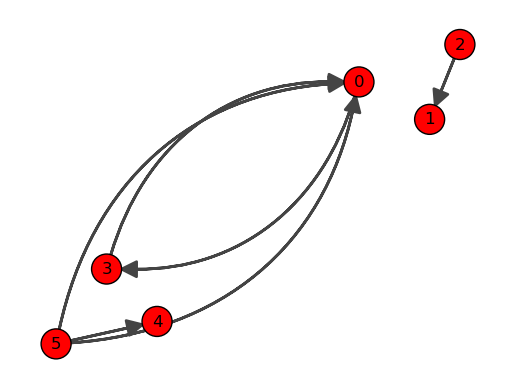

In [53]:
gen_net = gen_model_low_temp.generate(expected_num_edges=12)
visualize_graph_from_matrix(gen_net, test_embeddings)

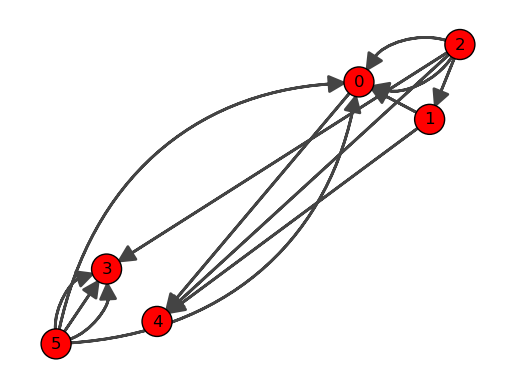

In [60]:
gen_net = gen_model_uncoupled.generate(expected_num_edges=12)
visualize_graph_from_matrix(gen_net, test_embeddings)

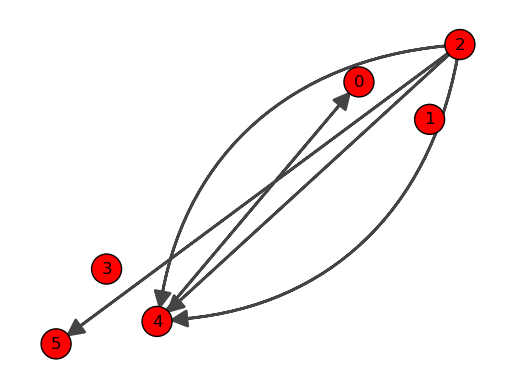

In [61]:
gen_net = gen_model_coupled.generate(expected_num_edges=12)
visualize_graph_from_matrix(gen_net, test_embeddings)

In [123]:
# test embeddings for attention model
jocks_goths_status = np.array([
    [4, 0], # jocks
    [3, 0],
    [2, 0],
    [1, 0],
    [-4, 0], # goths
    [-3, 0],
    [-2, 0],
    [-1, 0]
])
jocks_goths_prefs = jocks_goths_status.copy()
classes = [0, 0, 0, 0, 1, 1, 1, 1]

In [166]:
gen_attention_model = SpringAttentionModel(X=jocks_goths_prefs, Y=jocks_goths_status, beta=1, alpha=10)

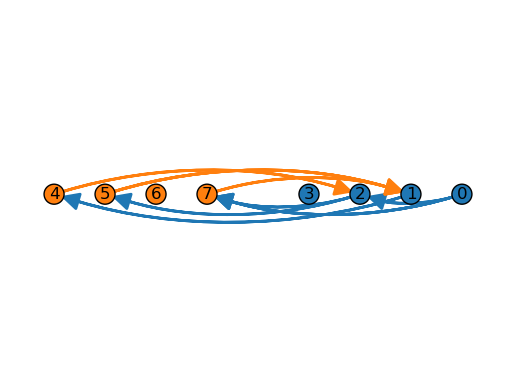

In [167]:
gen_net = gen_attention_model.generate(expected_num_edges=8)
visualize_graph_from_matrix(gen_net, jocks_goths_status, classes)

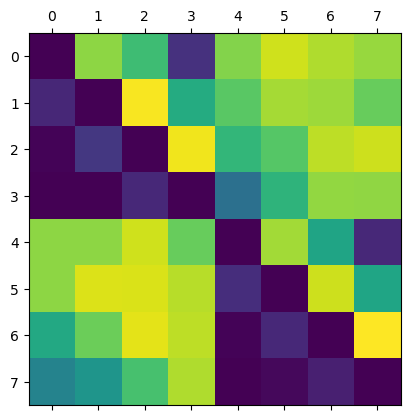

In [168]:
A = np.zeros((8, 8))
for i in range(1000):
    A += gen_attention_model.generate(expected_num_edges=8)
plt.matshow(A)

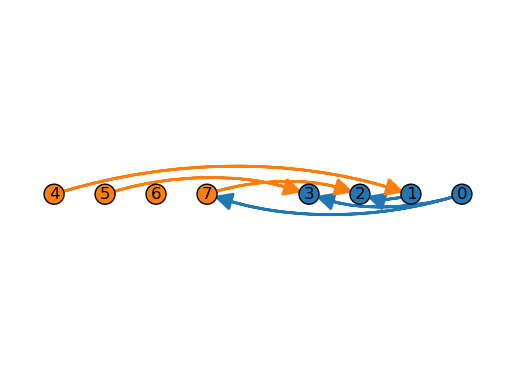

In [171]:
# try changing a few preferences
jocks_goths_prefs2 = jocks_goths_prefs.copy()
jocks_goths_prefs2[0] = [0, 1] # queen of the jocks has orthogonal preference
gen_attention_model2 = SpringAttentionModel(X=jocks_goths_prefs2, Y=jocks_goths_status, beta=1, alpha=10)
gen_net = gen_attention_model2.generate(expected_num_edges=8)
visualize_graph_from_matrix(gen_net, jocks_goths_status, classes)

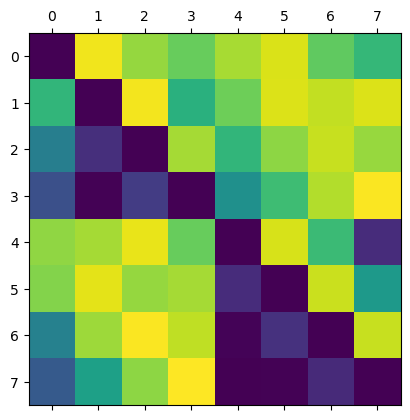

In [170]:
A = np.zeros((8, 8))
for i in range(1000):
    A += gen_attention_model2.generate(expected_num_edges=8)
plt.matshow(A)